In [1]:
import os
import sys
import json
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp

from tensorflow import keras
from itertools import combinations
from scipy.stats import shapiro, f_oneway, kruskal
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.plotting import plot_bars, plot_bar_from_dict

WIDTH = 150
HEIGHT = 150

In [32]:
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH),
    shuffle=False)

Found 2000 files belonging to 7 classes.


In [13]:
ROOT_NAME = 'xception_dealing_with_imbalance'
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
model_file_names = list(filter(lambda model_file_name: ROOT_NAME in model_file_name, os.listdir(models_dir)))

In [14]:
def get_accuracies_and_losses(models: list[str]) -> (dict[str, float], dict[str, float]):
    accuracies = {}
    losses = {}

    for model_name in models:
        model_path = os.path.join(models_dir, model_name)
        model = keras.models.load_model(model_path)
        loss, _, _, accuracy, _, _ = model.evaluate(test_ds)
        accuracies[model_name] = accuracy
        losses[model_name] = loss

    return accuracies, losses

In [15]:
accuracies_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_accuracies.json')
losses_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_losses.json')

In [16]:
if not os.path.exists(accuracies_file):
    accuracies, losses = get_accuracies_and_losses(model_file_names)

    with open(accuracies_file, 'w') as json_file:
        json.dump(accuracies, json_file, indent=4)
    with open(losses_file, 'w') as json_file:
        json.dump(losses, json_file, indent=4)

63/63 [==============================] - 4s 38ms/step - loss: 0.6281 - categorical cross entropy: 0.6281 - mean squared error: 0.0436 - accuracy: 0.7780 - auc: 0.9046 - prc: 0.5536


In [17]:
with open(accuracies_file, 'r') as accuracies_file_handle:
    accuracies = json.load(accuracies_file_handle)
with open(losses_file, 'r') as losses_file_handle:
    losses = json.load(losses_file_handle)

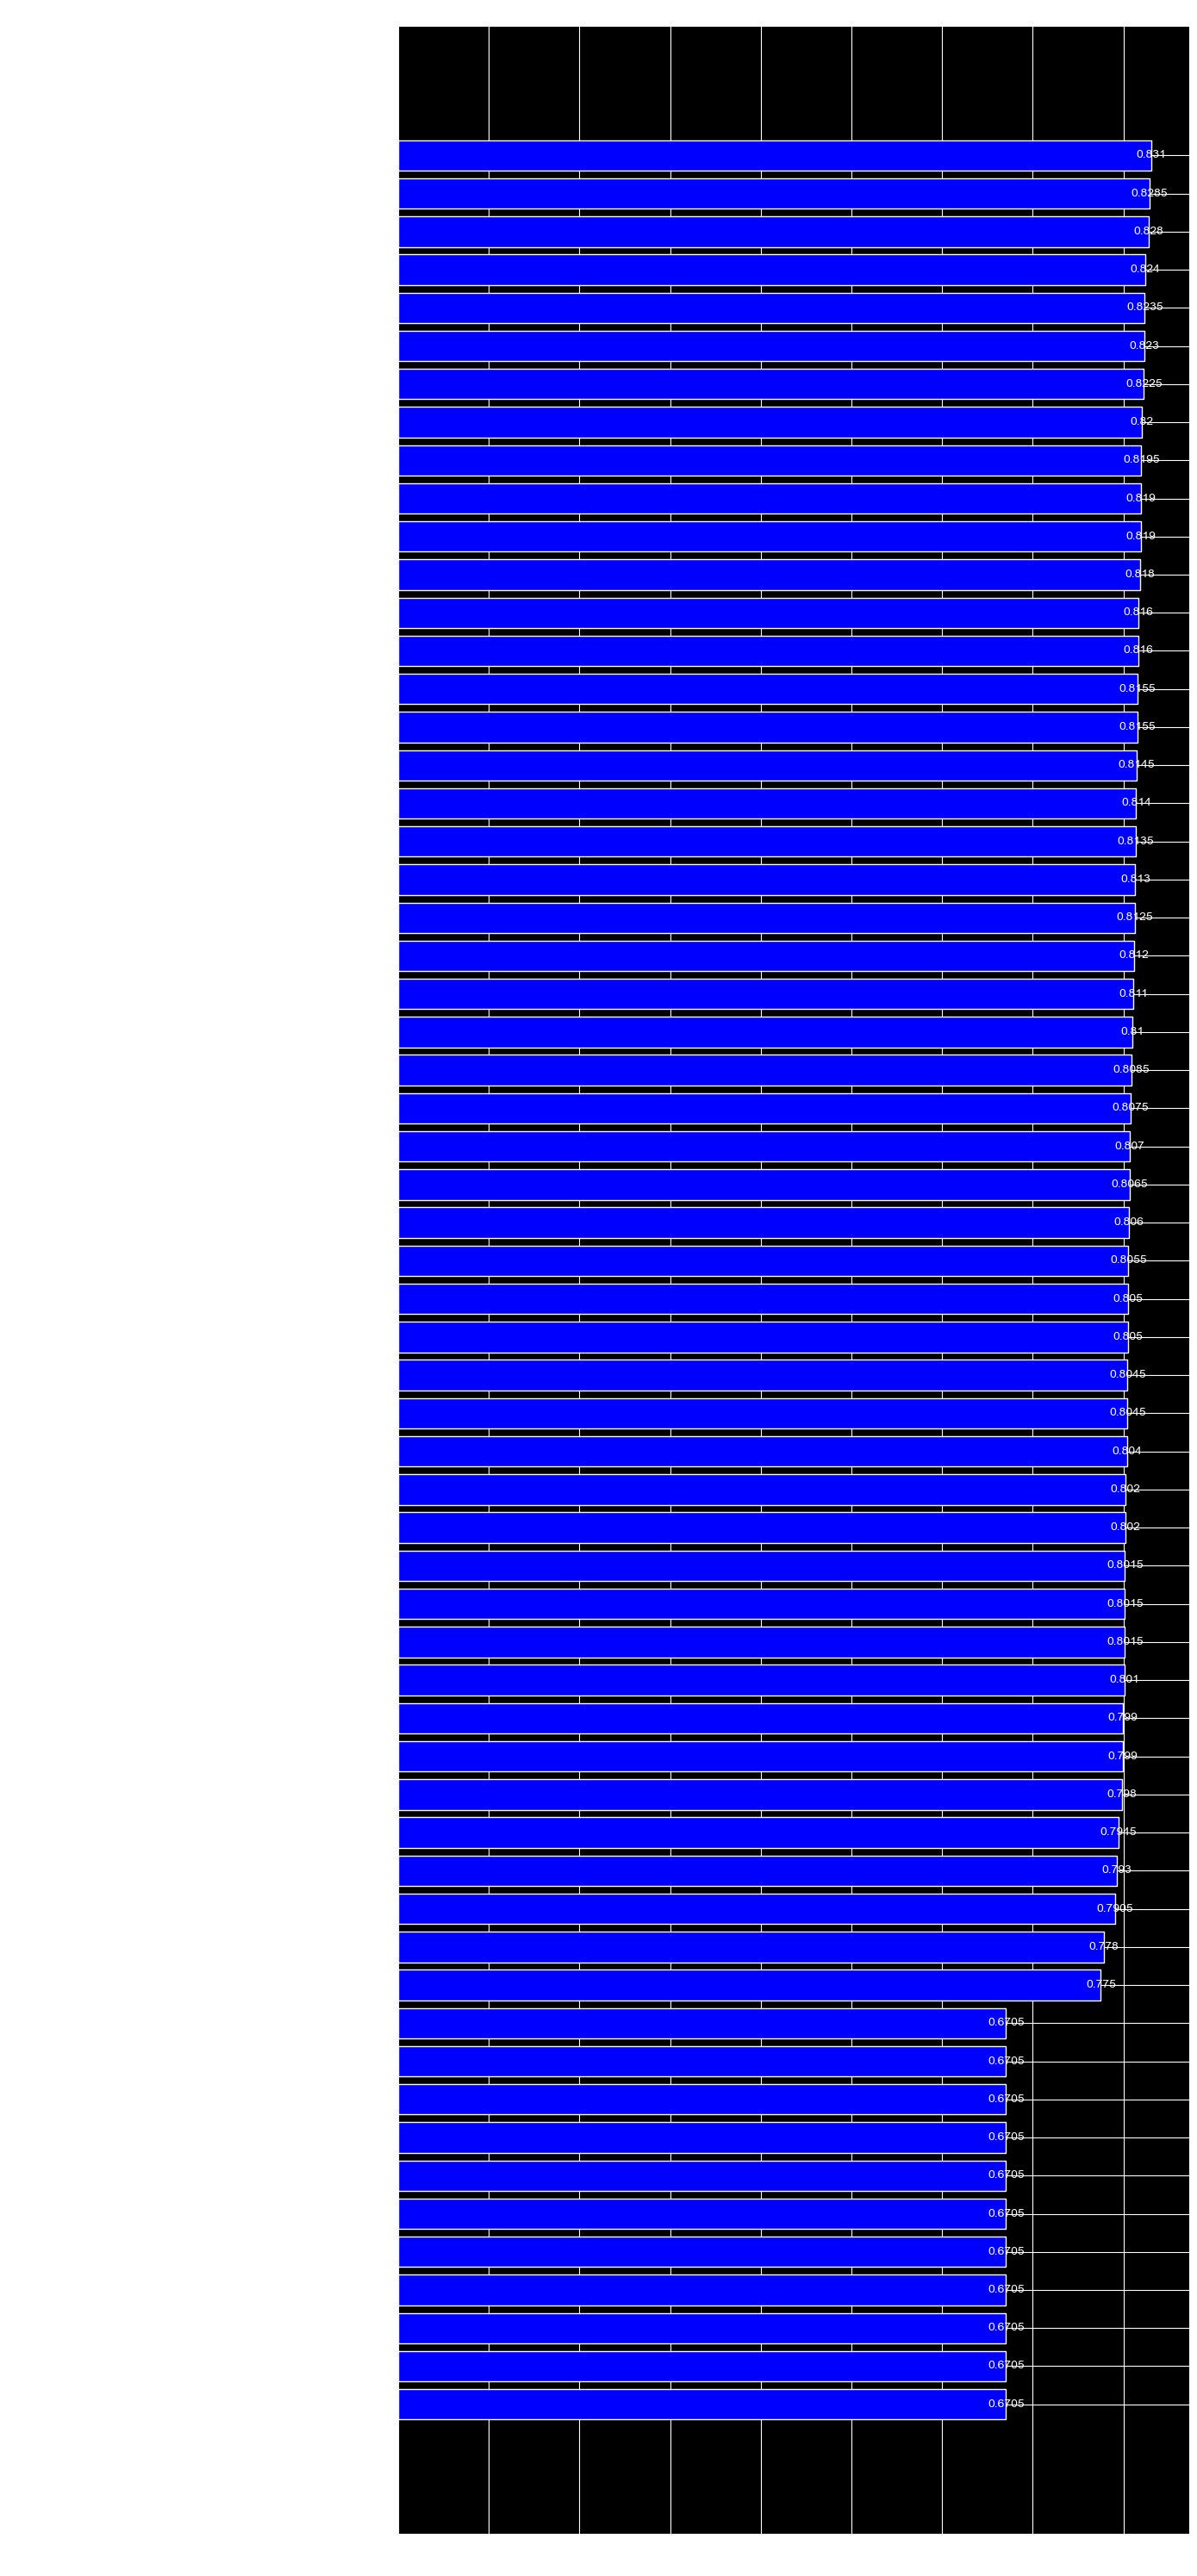

In [18]:
root = os.path.join('..', '..', 'plots', 'testing')
accuracies_pdf_path = os.path.join(root, f'{ROOT_NAME}_accuracies.pdf')

plot_bar_from_dict(accuracies, 'Model Accuracies', 'Name', 'Accuracy', accuracies_pdf_path)

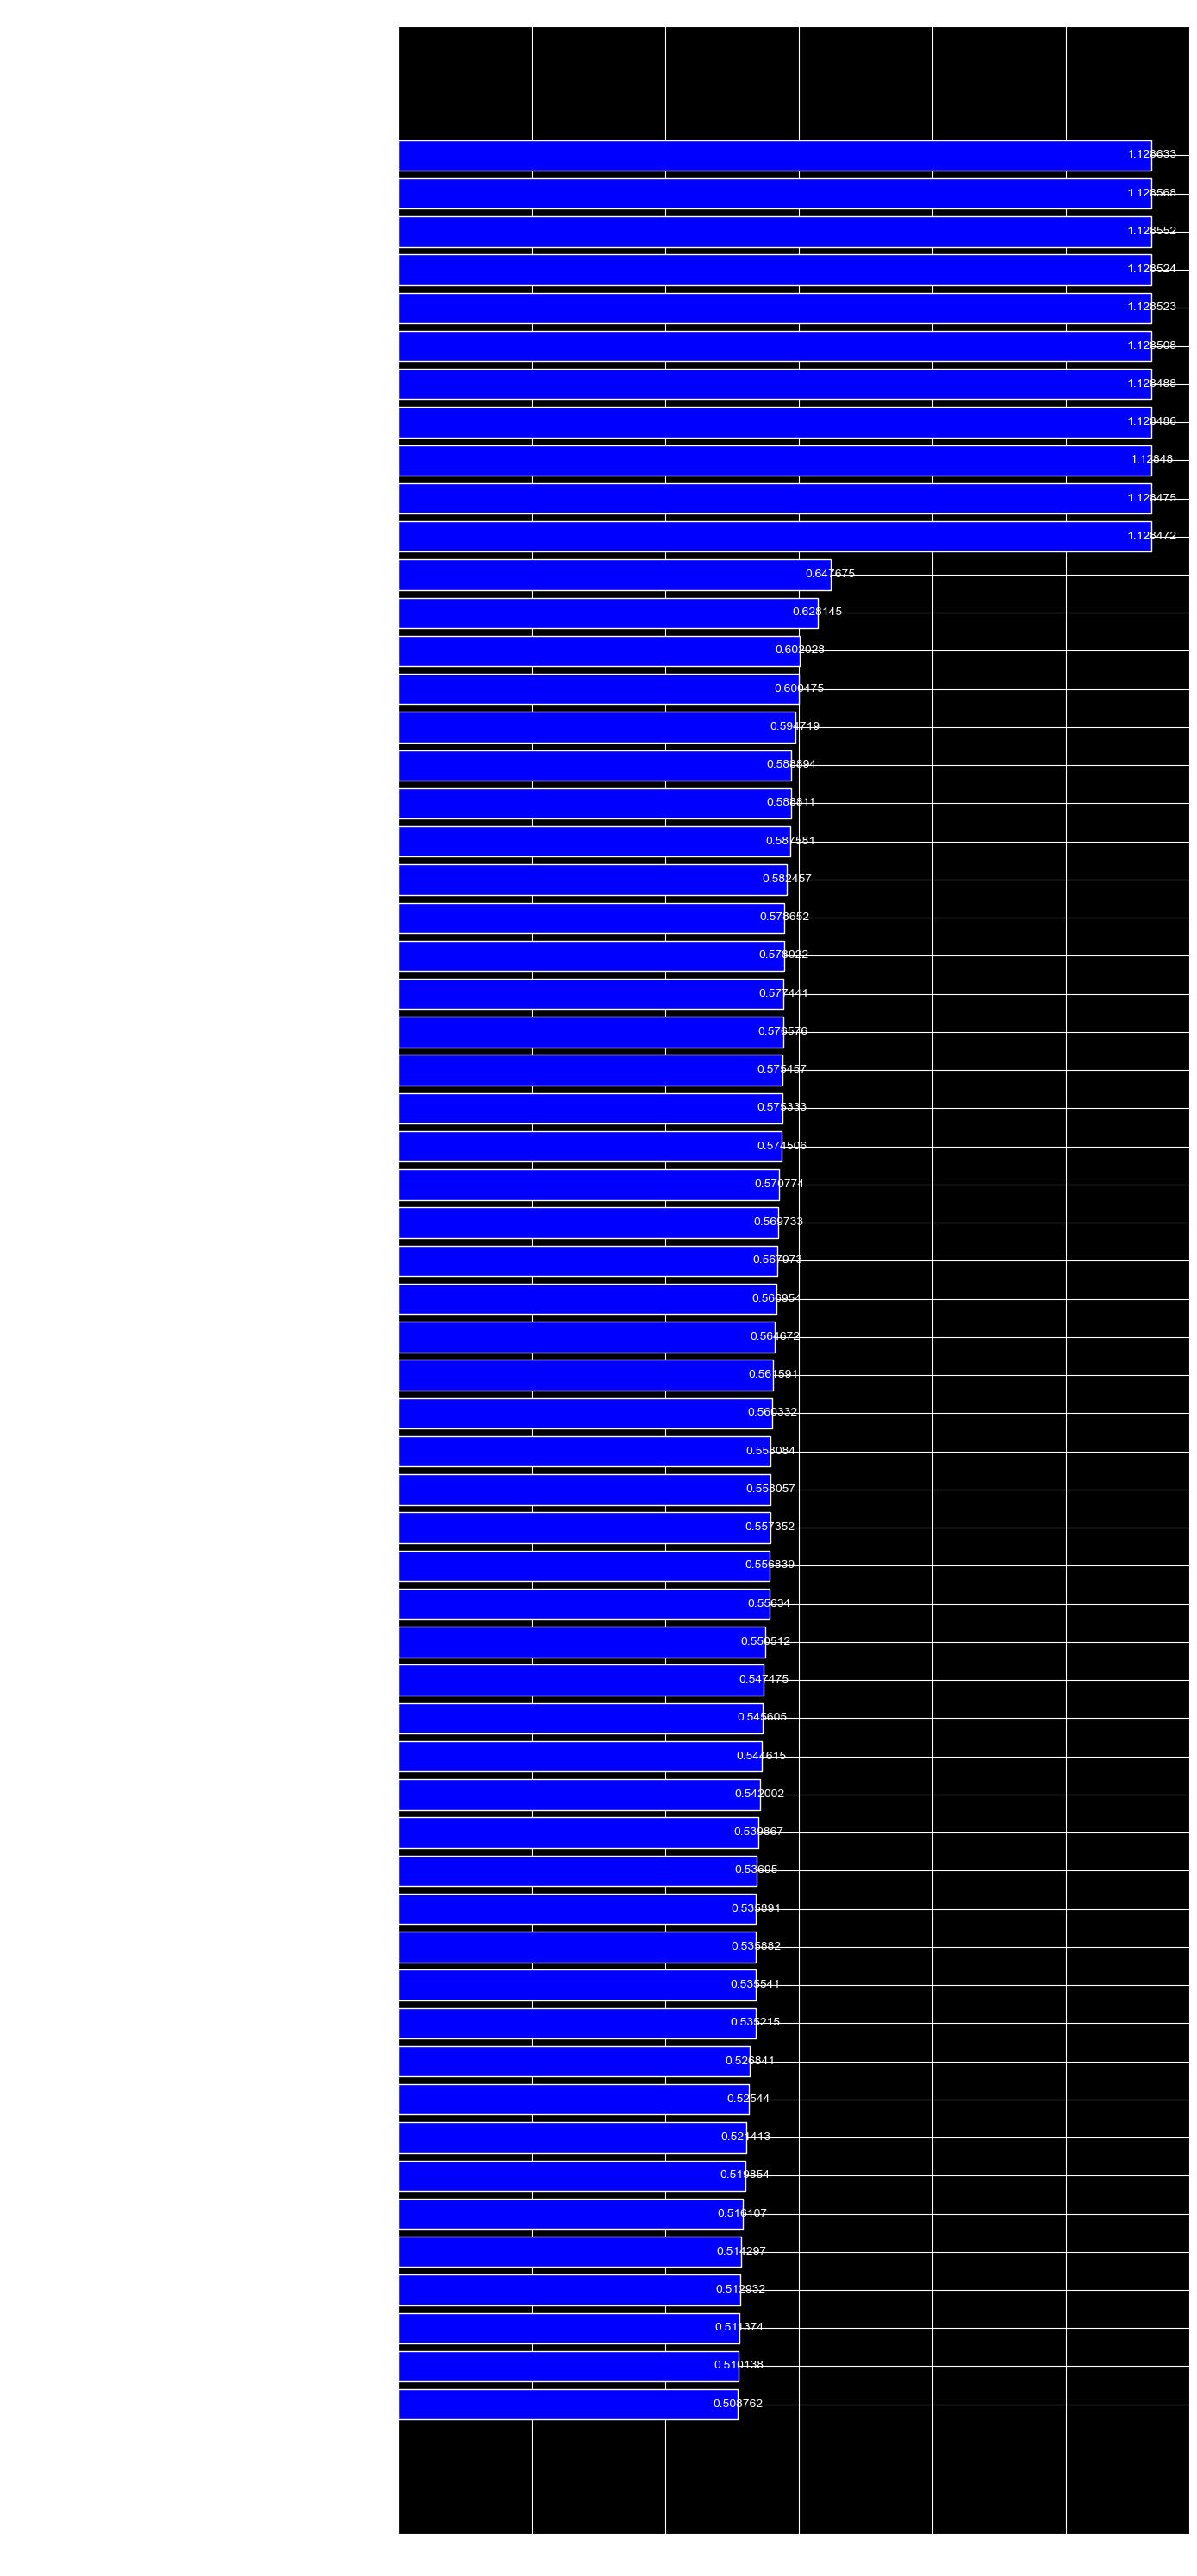

In [19]:
losses_pdf_path = os.path.join(root, f'{ROOT_NAME}_losses.pdf')

plot_bar_from_dict(losses, 'Model Losses', 'Name', 'Accuracy', losses_pdf_path)

In [20]:
model_categories = set(map(lambda name: '_'.join(name.split('_')[:-2]), model_file_names))
grouped_models = {key: list(filter(lambda name: name.startswith(key), model_file_names)) for key in model_categories}
keyed_accuracies = {key: [] for key in grouped_models}
keyed_losses = {key: [] for key in grouped_models}


def categorize_numbers(for_dict: dict[str, list[float]], numbers_dict: dict[str, float]) -> None:
    for group, value in for_dict.items():
        vals = [
            value for key, value in numbers_dict.items()
            if key.startswith(group)]

        value.extend(vals)


categorize_numbers(keyed_accuracies, accuracies)
categorize_numbers(keyed_losses, losses)

In [21]:
ALPHA = .05
anova_testable_groups = []
kruskal_walis_testable_groups = []


def assign_models_to_groups(models: list[float], col: str) -> None:
    _, p_value = shapiro(models)

    if p_value >= ALPHA:
        anova_testable_groups.append(col)
    else:
        kruskal_walis_testable_groups.append(col)


keys = list(keyed_accuracies.keys())

for idx in range(len(keys)):
    assign_models_to_groups(keyed_accuracies[keys[idx]], keys[idx])

In [22]:
kruskal_values = []

for col in kruskal_walis_testable_groups:
    kruskal_values.append(keyed_accuracies[col])

h_stat_kruskal, p_value_kruskal = kruskal(*kruskal_values)

print(f'Kruskal-Wallis p-value: {p_value_kruskal}')

Kruskal-Wallis p-value: 0.06937473873227626


Kruskal-Wallis p-value is bigger than the assumed 0.05 ALPHA value, therefore null hypothesis cannot be rejected. It seems that on average despite a model being bias-only initialized or using oversampling, it approximately as good as the other ones. Let's pick the best one and see the confusion matrix.

In [33]:
model_name = ''
best_acc = 0

for key, value in accuracies.items():
    if 'xception_dealing_with_imbalance' in key and value > best_acc:
        model_name = key
        best_acc = value

model_path = os.path.join(models_dir, model_name)
chosen_model = keras.models.load_model(model_path)
prediction = chosen_model.predict(test_ds)

63/63 [==============================] - 3s 37ms/step


In [34]:
y_pred_labels = np.argmax(prediction, axis=1)
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)

In [35]:
def show_report(y_pred) -> None:
    report = classification_report(y_test, y_pred, target_names=test_ds.class_names, zero_division=0)
    print(report)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

       akiec       0.65      0.43      0.52        65
         bcc       0.63      0.72      0.67       102
         bkl       0.68      0.68      0.68       219
          df       0.67      0.52      0.59        23
         mel       0.71      0.37      0.49       222
          nv       0.88      0.97      0.92      1341
        vasc       0.96      0.79      0.86        28

    accuracy                           0.83      2000
   macro avg       0.74      0.64      0.68      2000
weighted avg       0.82      0.83      0.82      2000



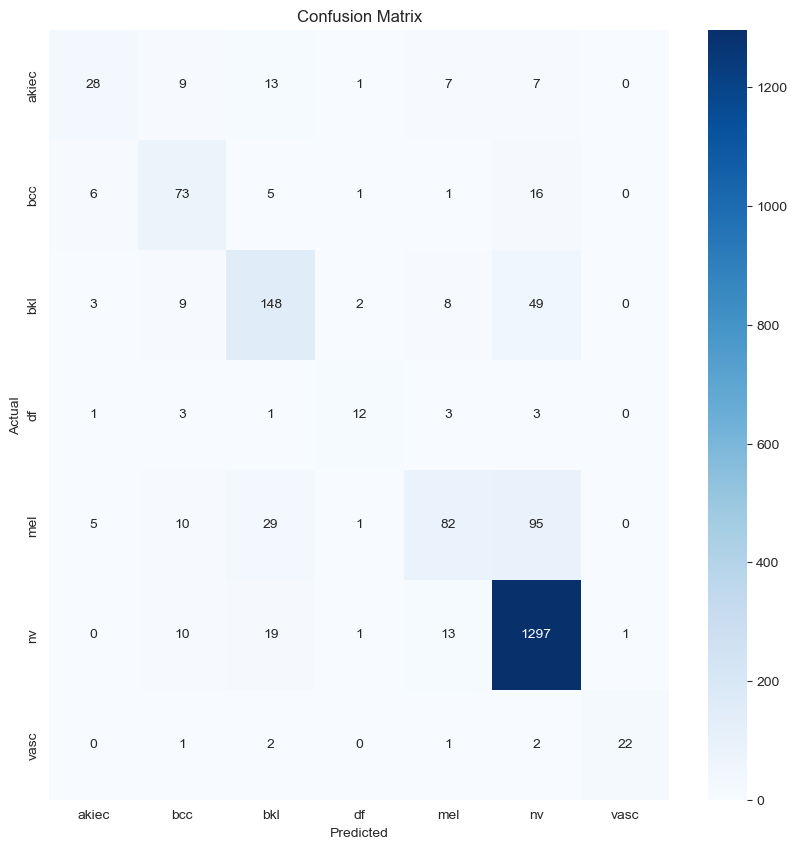

In [36]:
show_report(y_pred_labels)